# Info GAN

In [1]:
from __future__ import print_function

import tensorflow as tf
import tensorflow.contrib.distributions as ds
from tensorflow.examples.tutorials.mnist import input_data
slim = tf.contrib.slim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from six.moves import xrange
import os

%matplotlib inline

print('PACKAGES ARE LOADED')

PACKAGES ARE LOADED


## DEFINE FUNCTIONS TO VISUALIZE

In [2]:
def plot(samples, figsize=(5, 6), grid=(5, 6)):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(grid[0], grid[1])
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

## DEFINE FUNCTIONS FOR NETWORKS

In [3]:
def lrelu(x, leak=0.1, name='lrelu'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * tf.abs(x)


def generator(z, c, is_training=False):
    with tf.variable_scope('generator'):
        with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose],
                            normalizer_fn=slim.batch_norm,
                            normalizer_params={'is_training': is_training,
                                               'decay': 0.9,
                                               'updates_collections': None}):
            inputs = tf.concat([z, c], axis=1, name='inputs')
            fc1 = slim.fully_connected(inputs, 1024, scope='fc1')
            fc2 = slim.fully_connected(fc1, 7*7*128, scope='fc2')
            fc2_ = tf.reshape(fc2, [-1, 7, 7, 128], 'fc2_')
            conv3 = slim.conv2d_transpose(fc2_, 64, [4, 4], stride=2, scope='conv3')
            conv4 = slim.conv2d_transpose(conv3, 1, [4, 4], stride=2, 
                                          normalizer_fn=None,
                                          activation_fn=None,
                                          scope='conv4')

    return conv4


def discriminator(x, is_training=False, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        with slim.arg_scope([slim.conv2d, slim.fully_connected],
                            normalizer_fn=slim.batch_norm,
                            normalizer_params={'is_training': is_training,
                                               'decay': 0.9,
                                               'updates_collections': None},
                            activation_fn=lrelu):
            conv1 = slim.conv2d(x, 64, [4, 4], stride=2, normalizer_fn=None, scope='conv1')
            conv2 = slim.conv2d(conv1, 128, [4, 4], stride=2, scope='conv2')
            conv2_ = tf.reshape(conv2, [-1, 7*7*128], name='conv2_')
            fc3 = slim.fully_connected(conv2_, 1024, scope='fc3')
            fc4_d = slim.fully_connected(fc3, 1, normalizer_fn=None,
                                       activation_fn=tf.nn.sigmoid, scope='fc4_d')
            
    return fc4_d, fc3


def qnetwork(x, is_training=False):
    _, fc3 = discriminator(x, is_training=False, reuse=True)
    with tf.variable_scope('qnetwork'):
        fc4 = slim.fully_connected(fc3, 128,
                                     normalizer_fn=slim.batch_norm,
                                     normalizer_params={'is_training': is_training,
                                                        'decay': 0.9,
                                                        'updates_collections': None},
                                     activation_fn=lrelu,
                                     scope='fc4')
        fc5 = slim.fully_connected(fc4, 14, activation_fn=None, scope='fc5')
    return fc5

print('FUNCTIONS ARE READY')

FUNCTIONS ARE READY


## CONSTRUCT NETWORKS

In [4]:
# Set dimensions
Z_dim = 62
C_dim = 12
C1_dim = 10
C2loc_dim = 12

# Make Networks
X = tf.placeholder(tf.float32, [None, 784], name='X')
Z = tf.placeholder(tf.float32, [None, Z_dim], name='Z')
C = tf.placeholder(tf.float32, [None, C_dim], name='C')
is_training = tf.placeholder(tf.bool, [], name='is_training')

X_ = tf.reshape(X, [-1, 28, 28, 1], name='X_')
G_sample = generator(Z, C, is_training)
D_real = discriminator(X_, is_training)[0]
D_fake = discriminator(G_sample, is_training, reuse=True)[0]
Q_c_given_x = qnetwork(G_sample, is_training)

print('NETWORKS ARE READY')

NETWORKS ARE READY


## DEFINE LOSSES AND SOLVERS

In [5]:
# Define Losses
D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8))

mvn = ds.MultivariateNormalDiag(loc=Q_c_given_x[:, C1_dim:C2loc_dim],
                                scale_diag=tf.exp(Q_c_given_x[:, C2loc_dim:]))

Q_loss_categ = -tf.reduce_mean(
                    tf.reduce_sum(tf.log(tf.nn.softmax(Q_c_given_x[:, :C1_dim]) + 1e-8)
                                          * C[:, :C1_dim], 1)
                    + tf.reduce_sum(tf.log(C[:, :C1_dim] + 1e-8) * C[:, :C1_dim], 1))
Q_loss_conti = -tf.reduce_mean(mvn.log_prob(C[:, C1_dim:]))
Q_loss = Q_loss_categ + Q_loss_conti

# Define optimizers and solvers
D_vars = slim.get_model_variables('discriminator')
G_vars = slim.get_model_variables('generator')
Q_vars = slim.get_model_variables('qnetwork')

D_solver = tf.train.AdamOptimizer(0.0002, 0.5).minimize(D_loss, var_list=D_vars)
Q_solver = tf.train.AdamOptimizer(0.0002, 0.5).minimize(Q_loss, var_list=Q_vars + G_vars)
G_solver = tf.train.AdamOptimizer(0.0004, 0.5).minimize(G_loss, var_list=G_vars)

print('LOSSES AND SOLVERS ARE READY')

LOSSES AND SOLVERS ARE READY


## TRAINING LOOP

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: [0] [   1/1875], D_loss: 1.3534, G_loss: 0.7056, Q_bound: -4.7733


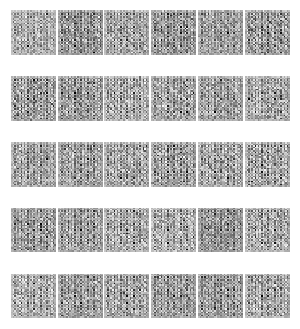

Epoch: [0] [ 101/1875], D_loss: 2.3865, G_loss: 0.6781, Q_bound: -4.4620
Epoch: [0] [ 201/1875], D_loss: 3.9386, G_loss: 1.2595, Q_bound: -3.4735
Epoch: [0] [ 301/1875], D_loss: 4.6257, G_loss: 1.3939, Q_bound: -2.6704
Epoch: [0] [ 401/1875], D_loss: 4.4522, G_loss: 0.8633, Q_bound: -3.0147
Epoch: [0] [ 501/1875], D_loss: 5.1342, G_loss: 0.9693, Q_bound: -2.2586
Epoch: [0] [ 601/1875], D_loss: 3.8137, G_loss: 0.7899, Q_bound: -2.5997
Epoch: [0] [ 701/1875], D_loss: 3.0114, G_loss: 0.8933, Q_bound: -2.0392
Epoch: [0] [ 801/1875], D_loss: 3.0706, G_loss: 0.7331, Q_bound: -2.2968
Epoch: [0] [ 901/1875], D_loss: 3.5144, G_loss: 1.3987, Q_bound: -2.2754


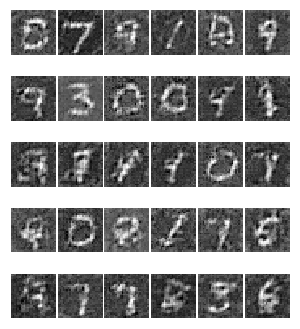

Epoch: [0] [1001/1875], D_loss: 2.3287, G_loss: 1.3441, Q_bound: -2.3065
Epoch: [0] [1101/1875], D_loss: 2.0892, G_loss: 0.7365, Q_bound: -2.4341
Epoch: [0] [1201/1875], D_loss: 2.6087, G_loss: 1.4678, Q_bound: -2.4068
Epoch: [0] [1301/1875], D_loss: 1.7626, G_loss: 2.0351, Q_bound: -1.8653
Epoch: [0] [1401/1875], D_loss: 2.9533, G_loss: 2.0213, Q_bound: -2.6286
Epoch: [0] [1501/1875], D_loss: 1.8255, G_loss: 1.1608, Q_bound: -2.4006
Epoch: [0] [1601/1875], D_loss: 3.4267, G_loss: 1.1890, Q_bound: -1.9898
Epoch: [0] [1701/1875], D_loss: 3.2451, G_loss: 2.7555, Q_bound: -5.3291
Epoch: [0] [1801/1875], D_loss: 1.4504, G_loss: 4.1929, Q_bound: -1.6648
Epoch: [1] [   1/1875], D_loss: 3.6683, G_loss: 1.8755, Q_bound: -1.4813


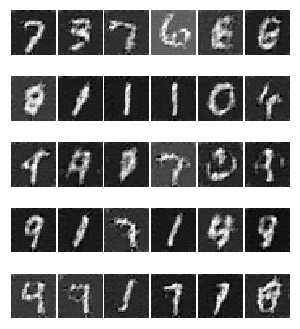

Epoch: [1] [ 101/1875], D_loss: 4.3863, G_loss: 3.3190, Q_bound: -2.0917
Epoch: [1] [ 201/1875], D_loss: 3.9078, G_loss: 1.6416, Q_bound: -1.0219
Epoch: [1] [ 301/1875], D_loss: 3.1484, G_loss: 1.0010, Q_bound: -1.2964
Epoch: [1] [ 401/1875], D_loss: 3.9899, G_loss: 2.8222, Q_bound: -1.4130
Epoch: [1] [ 501/1875], D_loss: 3.2581, G_loss: 1.9726, Q_bound: -1.2583
Epoch: [1] [ 601/1875], D_loss: 3.3974, G_loss: 1.5457, Q_bound: -2.8508
Epoch: [1] [ 701/1875], D_loss: 3.5842, G_loss: 6.0690, Q_bound: -1.6485
Epoch: [1] [ 801/1875], D_loss: 4.0734, G_loss: 2.9503, Q_bound: -1.5401
Epoch: [1] [ 901/1875], D_loss: 5.7731, G_loss: 1.1962, Q_bound: -1.7168


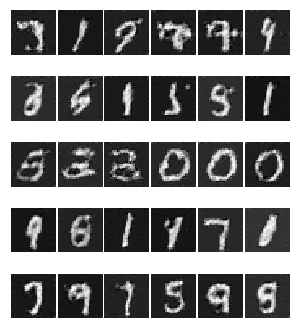

Epoch: [1] [1001/1875], D_loss: 3.7362, G_loss: 2.2444, Q_bound: -1.2968
Epoch: [1] [1101/1875], D_loss: 2.0678, G_loss: 1.3626, Q_bound: -9.0492
Epoch: [1] [1201/1875], D_loss: 3.1843, G_loss: 8.3969, Q_bound: -2.8820
Epoch: [1] [1301/1875], D_loss: 4.2110, G_loss: 2.1360, Q_bound: -0.2052
Epoch: [1] [1401/1875], D_loss: 3.2749, G_loss: 5.2755, Q_bound: -0.9988
Epoch: [1] [1501/1875], D_loss: 3.0070, G_loss: 6.7092, Q_bound: -0.8746
Epoch: [1] [1601/1875], D_loss: 2.9324, G_loss: 1.4398, Q_bound: -0.5887
Epoch: [1] [1701/1875], D_loss: 3.6508, G_loss: 2.9080, Q_bound: -0.9194
Epoch: [1] [1801/1875], D_loss: 2.1568, G_loss: 5.7058, Q_bound: -0.1133
Epoch: [2] [   1/1875], D_loss: 4.6462, G_loss: 3.5072, Q_bound: -0.3690


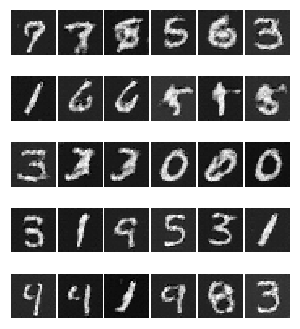

Epoch: [2] [ 101/1875], D_loss: 2.7638, G_loss: 1.2375, Q_bound: -0.3934
Epoch: [2] [ 201/1875], D_loss: 3.1038, G_loss: 3.1103, Q_bound: -0.1066
Epoch: [2] [ 301/1875], D_loss: 2.2676, G_loss: 1.3502, Q_bound: -0.3673
Epoch: [2] [ 401/1875], D_loss: 3.4150, G_loss: 4.4453, Q_bound: -0.2941
Epoch: [2] [ 501/1875], D_loss: 11.0818, G_loss: 4.9388, Q_bound: 0.0946
Epoch: [2] [ 601/1875], D_loss: 2.9655, G_loss: 2.5571, Q_bound: -0.7744
Epoch: [2] [ 701/1875], D_loss: 3.5532, G_loss: 3.6003, Q_bound: 0.1373
Epoch: [2] [ 801/1875], D_loss: 5.4469, G_loss: 15.0793, Q_bound: -7.2113
Epoch: [2] [ 901/1875], D_loss: 1.6967, G_loss: 8.1559, Q_bound: -1.0428


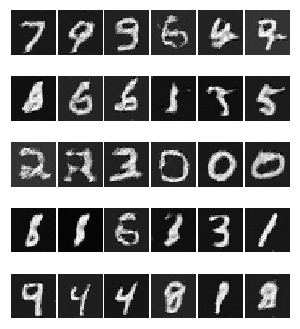

Epoch: [2] [1001/1875], D_loss: 0.6993, G_loss: 2.2503, Q_bound: -0.1442
Epoch: [2] [1101/1875], D_loss: 1.7689, G_loss: 5.5272, Q_bound: -0.1524
Epoch: [2] [1201/1875], D_loss: 2.2315, G_loss: 4.0089, Q_bound: 0.5476
Epoch: [2] [1301/1875], D_loss: 3.1839, G_loss: 3.1225, Q_bound: 0.5665
Epoch: [2] [1401/1875], D_loss: 1.6115, G_loss: 2.2346, Q_bound: 0.5131
Epoch: [2] [1501/1875], D_loss: 2.4953, G_loss: 1.9727, Q_bound: 0.7080
Epoch: [2] [1601/1875], D_loss: 2.4519, G_loss: 2.2810, Q_bound: 0.3967
Epoch: [2] [1701/1875], D_loss: 4.0762, G_loss: 4.4092, Q_bound: 0.7465
Epoch: [2] [1801/1875], D_loss: 2.8027, G_loss: 1.1526, Q_bound: 0.4537
Epoch: [3] [   1/1875], D_loss: 6.3804, G_loss: 4.9557, Q_bound: 0.9278


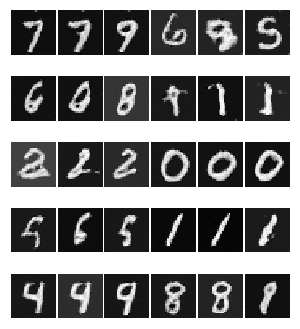

Epoch: [3] [ 101/1875], D_loss: 4.8393, G_loss: 3.8773, Q_bound: 0.7884
Epoch: [3] [ 201/1875], D_loss: 3.0781, G_loss: 11.2101, Q_bound: -0.0920
Epoch: [3] [ 301/1875], D_loss: 1.4633, G_loss: 2.9149, Q_bound: 0.8232
Epoch: [3] [ 401/1875], D_loss: 3.6743, G_loss: 2.8650, Q_bound: 0.7458
Epoch: [3] [ 501/1875], D_loss: 1.5127, G_loss: 2.3530, Q_bound: 0.7820
Epoch: [3] [ 601/1875], D_loss: 2.9715, G_loss: 1.8935, Q_bound: 1.0263
Epoch: [3] [ 701/1875], D_loss: 2.1605, G_loss: 1.4795, Q_bound: 0.9767
Epoch: [3] [ 801/1875], D_loss: 3.4221, G_loss: 2.4394, Q_bound: 1.0371
Epoch: [3] [ 901/1875], D_loss: 3.5805, G_loss: 5.0963, Q_bound: 1.0635


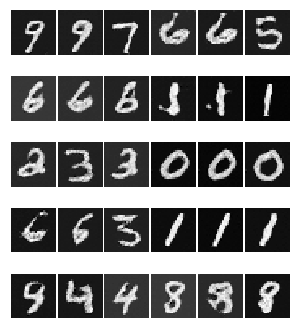

Epoch: [3] [1001/1875], D_loss: 1.9693, G_loss: 2.7410, Q_bound: 1.0152
Epoch: [3] [1101/1875], D_loss: 2.6894, G_loss: 1.8886, Q_bound: 0.7568
Epoch: [3] [1201/1875], D_loss: 1.2357, G_loss: 2.4305, Q_bound: 0.7631
Epoch: [3] [1301/1875], D_loss: 1.0843, G_loss: 1.5696, Q_bound: 0.8861
Epoch: [3] [1401/1875], D_loss: 1.3447, G_loss: 5.7703, Q_bound: 1.1942
Epoch: [3] [1501/1875], D_loss: 2.4648, G_loss: 2.0762, Q_bound: 1.1266
Epoch: [3] [1601/1875], D_loss: 1.4829, G_loss: 2.0426, Q_bound: 1.1579
Epoch: [3] [1701/1875], D_loss: 3.0977, G_loss: 3.8080, Q_bound: 0.9210
Epoch: [3] [1801/1875], D_loss: 1.4052, G_loss: 1.8292, Q_bound: 1.1458
Epoch: [4] [   1/1875], D_loss: 1.8863, G_loss: 3.2019, Q_bound: 1.1892


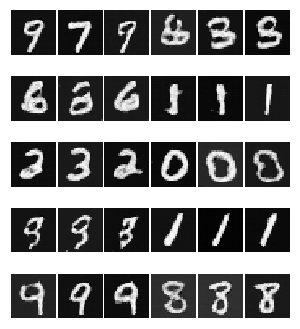

Epoch: [4] [ 101/1875], D_loss: 2.3057, G_loss: 3.6049, Q_bound: 1.2691
Epoch: [4] [ 201/1875], D_loss: 2.9867, G_loss: 2.0436, Q_bound: 0.7342
Epoch: [4] [ 301/1875], D_loss: 1.5975, G_loss: 2.6325, Q_bound: 1.1915
Epoch: [4] [ 401/1875], D_loss: 3.6330, G_loss: 2.2825, Q_bound: 1.2726
Epoch: [4] [ 501/1875], D_loss: 2.2542, G_loss: 1.3767, Q_bound: 1.3179
Epoch: [4] [ 601/1875], D_loss: 0.8765, G_loss: 1.6648, Q_bound: 1.1978
Epoch: [4] [ 701/1875], D_loss: 1.4122, G_loss: 1.8762, Q_bound: 0.9923
Epoch: [4] [ 801/1875], D_loss: 0.6344, G_loss: 2.4530, Q_bound: 1.3468
Epoch: [4] [ 901/1875], D_loss: 1.1195, G_loss: 1.8157, Q_bound: 1.4236


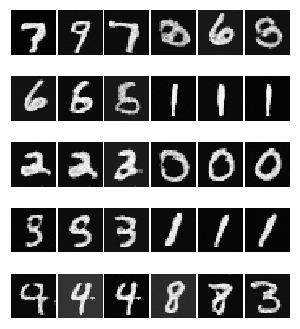

Epoch: [4] [1001/1875], D_loss: 0.9234, G_loss: 1.4609, Q_bound: 1.2463
Epoch: [4] [1101/1875], D_loss: 1.1962, G_loss: 1.8155, Q_bound: 1.3678
Epoch: [4] [1201/1875], D_loss: 1.8415, G_loss: 1.6613, Q_bound: 1.2000
Epoch: [4] [1301/1875], D_loss: 1.8804, G_loss: 5.4704, Q_bound: 1.1255
Epoch: [4] [1401/1875], D_loss: 2.0275, G_loss: 5.5433, Q_bound: 1.0459
Epoch: [4] [1501/1875], D_loss: 1.5043, G_loss: 1.5093, Q_bound: 1.3602
Epoch: [4] [1601/1875], D_loss: 0.7572, G_loss: 1.7836, Q_bound: 0.2523
Epoch: [4] [1701/1875], D_loss: 1.1482, G_loss: 2.3200, Q_bound: 0.9978
Epoch: [4] [1801/1875], D_loss: 1.1732, G_loss: 1.3301, Q_bound: 1.4322
Epoch: [5] [   1/1875], D_loss: 0.9279, G_loss: 2.7750, Q_bound: 1.1718


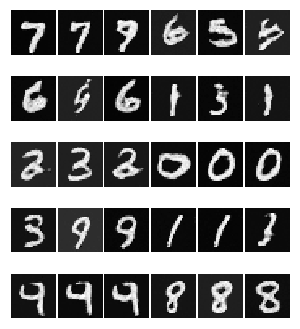

Epoch: [5] [ 101/1875], D_loss: 3.2171, G_loss: 2.0591, Q_bound: 1.3641
Epoch: [5] [ 201/1875], D_loss: 0.8014, G_loss: 2.1910, Q_bound: 1.2002
Epoch: [5] [ 301/1875], D_loss: 0.7205, G_loss: 2.1421, Q_bound: 0.7093
Epoch: [5] [ 401/1875], D_loss: 0.9188, G_loss: 1.6649, Q_bound: 1.3307
Epoch: [5] [ 501/1875], D_loss: 1.6460, G_loss: 2.1614, Q_bound: 1.3548
Epoch: [5] [ 601/1875], D_loss: 1.1159, G_loss: 3.5145, Q_bound: 1.4218
Epoch: [5] [ 701/1875], D_loss: 1.2471, G_loss: 3.1336, Q_bound: 1.1571
Epoch: [5] [ 801/1875], D_loss: 0.6618, G_loss: 3.8115, Q_bound: 1.3836
Epoch: [5] [ 901/1875], D_loss: 1.1585, G_loss: 2.3927, Q_bound: 1.5236


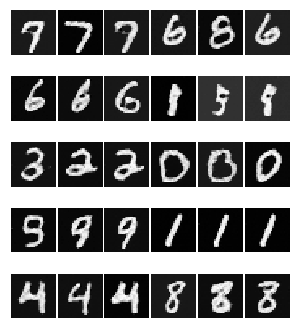

Epoch: [5] [1001/1875], D_loss: 2.6476, G_loss: 2.4173, Q_bound: 1.3296
Epoch: [5] [1101/1875], D_loss: 0.8133, G_loss: 1.8788, Q_bound: 1.3085
Epoch: [5] [1201/1875], D_loss: 0.7794, G_loss: 1.5824, Q_bound: 1.4885
Epoch: [5] [1301/1875], D_loss: 1.3635, G_loss: 2.2823, Q_bound: 1.4482
Epoch: [5] [1401/1875], D_loss: 1.7708, G_loss: 2.9852, Q_bound: 1.5126
Epoch: [5] [1501/1875], D_loss: 1.7413, G_loss: 8.6202, Q_bound: 0.9928
Epoch: [5] [1601/1875], D_loss: 1.0377, G_loss: 1.3410, Q_bound: 1.4469
Epoch: [5] [1701/1875], D_loss: 1.6219, G_loss: 4.8788, Q_bound: 1.1571
Epoch: [5] [1801/1875], D_loss: 0.6932, G_loss: 6.6740, Q_bound: 1.1791
Epoch: [6] [   1/1875], D_loss: 0.9370, G_loss: 3.7116, Q_bound: 1.3513


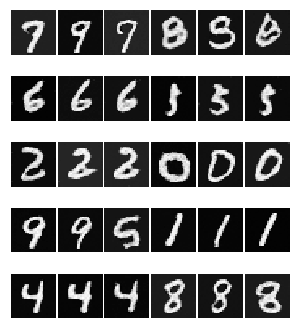

Epoch: [6] [ 101/1875], D_loss: 0.6571, G_loss: 1.6524, Q_bound: 1.2407
Epoch: [6] [ 201/1875], D_loss: 1.0449, G_loss: 3.6981, Q_bound: 1.4187
Epoch: [6] [ 301/1875], D_loss: 1.5948, G_loss: 2.1415, Q_bound: 1.1566
Epoch: [6] [ 401/1875], D_loss: 0.9675, G_loss: 1.9789, Q_bound: 1.4214
Epoch: [6] [ 501/1875], D_loss: 0.6415, G_loss: 3.0326, Q_bound: 1.4999
Epoch: [6] [ 601/1875], D_loss: 0.7989, G_loss: 1.7043, Q_bound: 1.4436
Epoch: [6] [ 701/1875], D_loss: 0.7602, G_loss: 5.3039, Q_bound: 1.2980
Epoch: [6] [ 801/1875], D_loss: 0.8715, G_loss: 2.3117, Q_bound: 1.4071
Epoch: [6] [ 901/1875], D_loss: 0.6538, G_loss: 2.3516, Q_bound: 1.4172


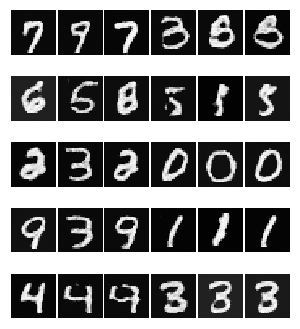

Epoch: [6] [1001/1875], D_loss: 0.8498, G_loss: 3.5948, Q_bound: 1.4968
Epoch: [6] [1101/1875], D_loss: 0.6161, G_loss: 2.1065, Q_bound: 1.4895
Epoch: [6] [1201/1875], D_loss: 0.4939, G_loss: 3.5786, Q_bound: 1.3072
Epoch: [6] [1301/1875], D_loss: 1.2268, G_loss: 2.6867, Q_bound: 1.4847
Epoch: [6] [1401/1875], D_loss: 0.7537, G_loss: 2.0504, Q_bound: 1.5948
Epoch: [6] [1501/1875], D_loss: 1.7565, G_loss: 3.6921, Q_bound: 1.5272
Epoch: [6] [1601/1875], D_loss: 1.1985, G_loss: 1.7755, Q_bound: 1.7423
Epoch: [6] [1701/1875], D_loss: 1.3090, G_loss: 2.0248, Q_bound: 1.5482
Epoch: [6] [1801/1875], D_loss: 1.3676, G_loss: 2.1477, Q_bound: 1.4763
TRAINING IS DONE


In [6]:
# Set training parameters
num_epoch = 7
num_train = 60000
size_batch = 32
num_batch = num_train // size_batch

mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess_config.allow_soft_placement = True

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

sess = tf.Session(config=sess_config)
sess.run(init_op)

C_sample = np.concatenate([np.eye(10)[np.repeat(range(10), 3)], np.zeros([30, 2])], axis=1)

for epoch in xrange(num_epoch):
    for i in xrange(num_batch):

        X_input, _ = mnist.train.next_batch(size_batch)
        Z_noise = np.random.uniform(-1., 1., [size_batch, Z_dim])
        C_noise = np.concatenate([np.random.multinomial(1, [0.1]*10, size=size_batch),
                                  np.random.uniform(-1., 1., [size_batch, 2])],
                                 axis=1)

        sess.run([D_solver], feed_dict={X: X_input,
                                        Z: Z_noise,
                                        C: C_noise,
                                        is_training: True})
        sess.run([G_solver], feed_dict={Z: Z_noise,
                                        C: C_noise,
                                        is_training: True})
        sess.run([Q_solver], feed_dict={Z: Z_noise,
                                        C: C_noise,
                                        is_training: True})

        D_loss_np, G_loss_np, Q_loss_np = sess.run([D_loss, G_loss, Q_loss],
                                                   feed_dict={X: X_input,
                                                              Z: Z_noise,
                                                              C: C_noise,
                                                              is_training: False})

        if i % 100 == 1:
            print('Epoch: [{}] [{:>4d}/{:>4d}], D_loss: {:.4f}, G_loss: {:.4f}, Q_bound: {:.4f}'\
                .format(epoch, i, num_batch, D_loss_np, G_loss_np, -Q_loss_np))

        if i % 950 == 1:
            Z_sample = np.random.uniform(-1., 1., [30, Z_dim])
            samples = sess.run(G_sample, feed_dict={Z: Z_sample,
                                                    C: C_sample,
                                                    is_training: False})
            fig = plot(samples)
            plt.show()

print('TRAINING IS DONE')

## VISUALIZE THE RESULTS

VARYING DISCRETE LATENT VAR


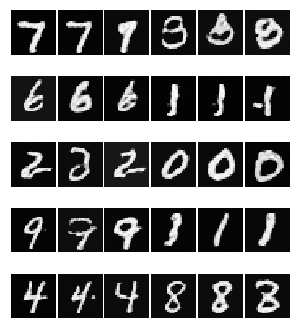

VARYING CONTINUOUS LATENT VAR 1


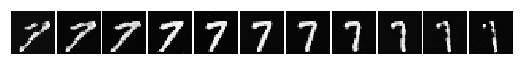

VARYING CONTINUOUS LATENT VAR 2


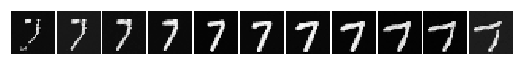

In [8]:
# Test the reuslt
Z_sample = np.random.uniform(-1., 1., [30, Z_dim])
Z_sample_ = np.zeros([11, Z_dim])
C_sample_1 = np.concatenate([np.eye(10)[[0]*11],
                             np.expand_dims(np.linspace(-2., 2., 11), axis=1),
                             np.zeros([11, 1])],
                            axis=1)
C_sample_2 = np.concatenate([np.eye(10)[[0]*11],
                             np.zeros([11, 1]),
                             np.expand_dims(np.linspace(-2., 2., 11), axis=1)],
                            axis=1)
samples = sess.run(G_sample, feed_dict={Z: Z_sample, C: C_sample, is_training: False})
samples_1 = sess.run(G_sample, feed_dict={Z: Z_sample_, C: C_sample_1, is_training: False})
samples_2 = sess.run(G_sample, feed_dict={Z: Z_sample_, C: C_sample_2, is_training: False})

print('VARYING DISCRETE LATENT VAR')
fig = plot(samples)
plt.show()
print('VARYING CONTINUOUS LATENT VAR 1')
fig = plot(samples_1, figsize=[9, 9*11], grid=[1, 11])
plt.show()
print('VARYING CONTINUOUS LATENT VAR 2')
fig = plot(samples_2, figsize=[9, 9*11], grid=[1, 11])
plt.show()